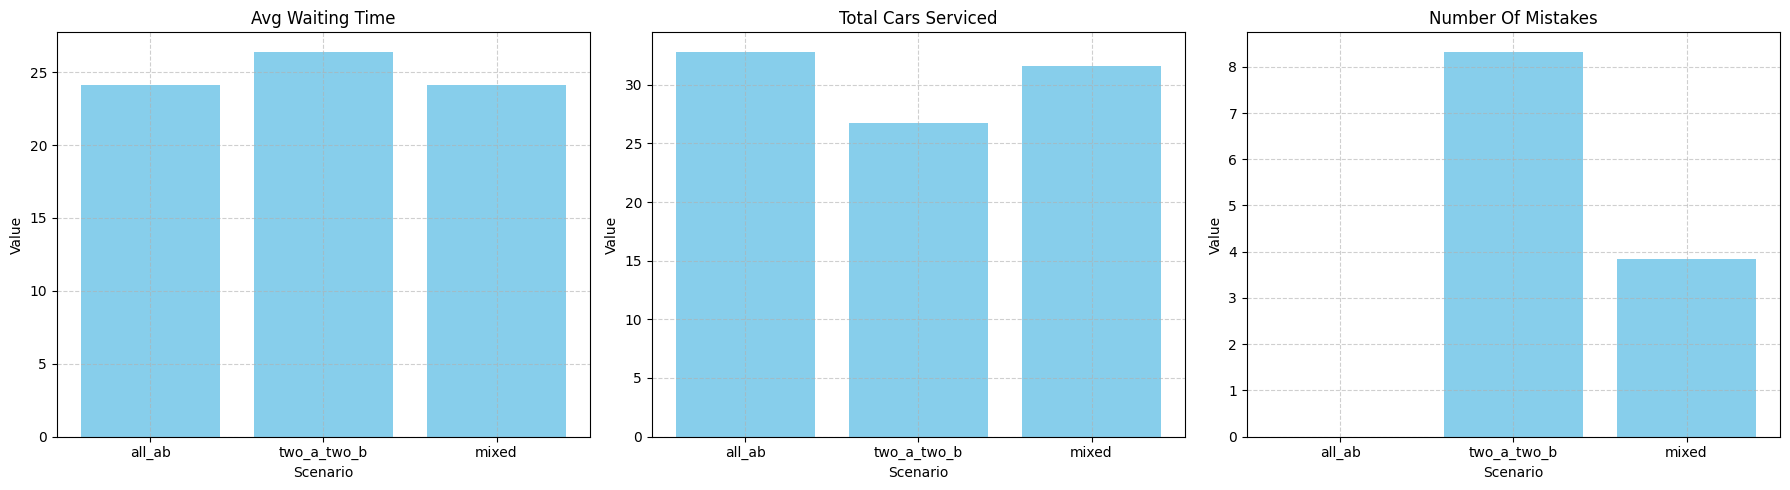

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from main import run_multiple_simulations, SCENARIOS


simulation_runs = 100
results = {}

for name, config_variant in SCENARIOS.items():
    _, stats_list = run_multiple_simulations(simulation_runs, config_variant)
    avg_stats = defaultdict(float)
    
    for stats in stats_list:
        for key, value in stats.items():
            if isinstance(value, dict):
                for sub_key, sub_val in value.items():
                    avg_stats[f"{key}_{sub_key}"] += sub_val
            else:
                avg_stats[key] += value

    for key in avg_stats:
        avg_stats[key] /= simulation_runs

    results[name] = dict(avg_stats)

results_df = pd.DataFrame(results).T

plot_columns = ["avg_waiting_time", "total_cars_serviced", "number_of_mistakes"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(plot_columns):
    axes[i].bar(results_df.index, results_df[col], color='skyblue')
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_ylabel("Value")
    axes[i].set_xlabel("Scenario")
    axes[i].grid(True, linestyle='--', alpha=0.6)
    
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind
from main import run_multiple_simulations, SCENARIOS


def estimate_sigma_delta(scenario_key, n=30):
    _, stats = run_multiple_simulations(n, SCENARIOS[scenario_key])
    waits = [s["avg_waiting_time"] for s in stats]
    return np.mean(waits), np.std(waits, ddof=1)

def compute_required_n(mean1, mean2, sigma1, sigma2, alpha=0.05, power=0.8):
    d = abs(mean1 - mean2) / np.sqrt((sigma1**2 + sigma2**2) / 2)
    analysis = TTestIndPower()
    n = analysis.solve_power(effect_size=d, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')
    return int(np.ceil(n)), d

def collect_waits(scenario_key, n):
    _, stats = run_multiple_simulations(n, SCENARIOS[scenario_key])
    return np.array([s["avg_waiting_time"] for s in stats])

def test_scenarios(s1, s2):
    μ1, σ1 = estimate_sigma_delta(s1)
    μ2, σ2 = estimate_sigma_delta(s2)
    print(f"{s1}: mean={μ1:.3f}, σ={σ1:.3f}")
    print(f"{s2}: mean={μ2:.3f}, σ={σ2:.3f}")
    n, d = compute_required_n(μ1, μ2, σ1, σ2)
    print(f"Effect size d={d:.3f}, potrzebne n={n} per grupa")
    data1 = collect_waits(s1, n)
    data2 = collect_waits(s2, n)
    t_stat, p_val = ttest_ind(data1, data2, equal_var=True)
    print(f"T-test {s1} vs {s2}: t={t_stat:.3f}, p={p_val:.4f}\n")


pairs = [("all_ab", "two_a_two_b"), ("all_ab", "mixed"), ("mixed", "two_a_two_b")]
for s1, s2 in pairs:
    test_scenarios(s1, s2)



all_ab: mean=23.377, σ=2.595
two_a_two_b: mean=27.235, σ=5.115
Effect size d=0.951, potrzebne n=19 per grupa
T-test all_ab vs two_a_two_b: t=-2.475, p=0.0182

all_ab: mean=25.500, σ=2.677
mixed: mean=24.588, σ=2.244
Effect size d=0.370, potrzebne n=116 per grupa
T-test all_ab vs mixed: t=0.233, p=0.8158

mixed: mean=24.678, σ=3.147
two_a_two_b: mean=26.177, σ=5.040
Effect size d=0.357, potrzebne n=125 per grupa
T-test mixed vs two_a_two_b: t=-7.301, p=0.0000



Current configuration:
simulation_duration: 100
min_service_time: 5
max_service_time: 15
fuels: ['A', 'B']
fuels_probability: [0.7, 0.3]
normal_arrival_mean: 2
normal_arrival_std: 0.5
queue_max_size: 12
dispenser_queue_max_size: 3
dispensers_config: {'all_ab': [{'id': 0, 'fuels': {'B', 'A'}}, {'id': 1, 'fuels': {'B', 'A'}}, {'id': 2, 'fuels': {'B', 'A'}}, {'id': 3, 'fuels': {'B', 'A'}}], 'two_a_two_b': [{'id': 0, 'fuels': {'A'}}, {'id': 1, 'fuels': {'A'}}, {'id': 2, 'fuels': {'B'}}, {'id': 3, 'fuels': {'B'}}], 'mixed': [{'id': 0, 'fuels': {'B', 'A'}}, {'id': 1, 'fuels': {'B', 'A'}}, {'id': 2, 'fuels': {'A'}}, {'id': 3, 'fuels': {'B'}}]}
Symulacja zakończona i statystyki zapisane do 'simulation_stats.csv'.

Regresja wieloraka - wyniki:
Współczynniki regresji: [ 0.83719611 -0.14269233 -0.46136367 -0.73228414 -1.07954101]
Wyraz wolny (intercept): 21.020201343790568
R^2: 0.41063613933592513


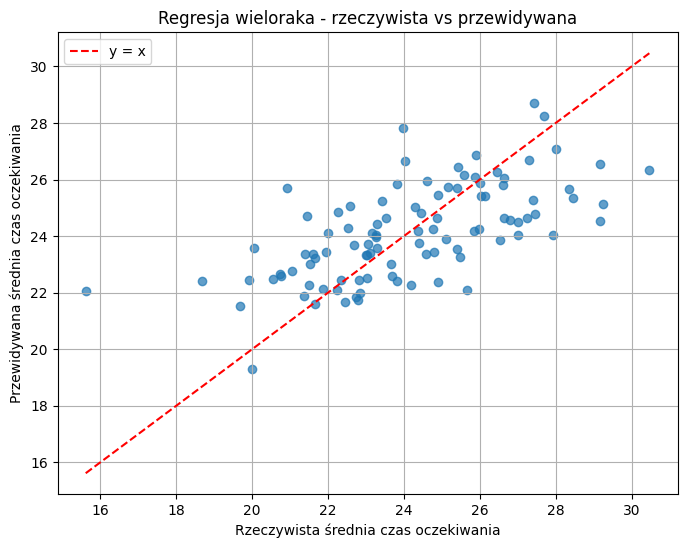

In [9]:
from main import (
    config,
    show_config,
    run_multiple_simulations,
    export_multiple_stats_to_csv,
)

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def prepare_regression_data(stats_list):
    y = []
    X = []
    for stats in stats_list:
        y.append(stats["avg_waiting_time"])
        features = [
            stats["total_cars_generated"],
            stats["number_of_mistakes"],
            stats["total_cars_in_main_queue_at_end"],
            stats["total_cars_in_mini_queues_at_end"],
            stats["total_cars_serviced"],
        ]
        X.append(features)
    return np.array(X), np.array(y)

def run_multiple_regression(stats_list):
    X, y = prepare_regression_data(stats_list)
    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    print("Regresja wieloraka - wyniki:")
    print(f"Współczynniki regresji: {model.coef_}")
    print(f"Wyraz wolny (intercept): {model.intercept_}")
    print(f"R^2: {model.score(X, y)}")

    # Wykres rzeczywistej vs przewidywanej średniej czasu oczekiwania
    plt.figure(figsize=(8,6))
    plt.scatter(y, y_pred, alpha=0.7)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='y = x')
    plt.xlabel("Rzeczywista średnia czas oczekiwania")
    plt.ylabel("Przewidywana średnia czas oczekiwania")
    plt.title("Regresja wieloraka - rzeczywista vs przewidywana")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    show_config()
    scenario = config["dispensers_config"]["mixed"]
    simulation_states, simulation_stats = run_multiple_simulations(100, scenario)
    export_multiple_stats_to_csv(simulation_stats, "simulation_stats.csv")
    print("Symulacja zakończona i statystyki zapisane do 'simulation_stats.csv'.\n")
    run_multiple_regression(simulation_stats)
